# Auto3D AutoRunner

An interface to run the Auto3Dseg pipeline in less than 5 lines of code

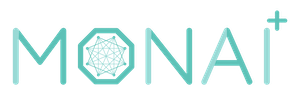

## 1. Prepare datasets and configuration
### 1.1 Download public datasets

In [ ]:
import os
from monai.bundle.config_parser import ConfigParser
from monai.apps import download_and_extract

root = "./"
msd_task = "Task05_Prostate"
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/" + msd_task + ".tar"
compressed_file = os.path.join(root, msd_task + ".tar")
if os.path.exists(root):
    download_and_extract(resource, compressed_file, root)

### 1.2. Prepare the input YAML configuration for the datasets

In [ ]:
data_src_cfg = {
    "name": "Task05_Prostate",
    "task": "segmentation",
    "modality": "MRI",
    "datalist": "../tasks/msd/Task05_Prostate/msd_task05_prostate_folds.json",  # data traning, validation, testing splits in a JSON file
    "dataroot": "./Task05_Prostate",  # location of the datasets
    "multigpu": True,
    "class_names": ["val_acc_pz", "val_acc_tz"]
}
input = './input.yaml'
ConfigParser.export_config_file(data_src_cfg, input)

## 2. Run the Auto3Dseg pipeline in a few lines of code
### 2.1 Use all default settings of the modules and complete (1) analysis (2) algo generation (3) training (4) algo ensemble in 3 lines

In [ ]:
from monai.apps.auto3dseg import AutoRunner
runner = AutoRunner(input=input)
runner.run()  # this will take a long time because algos are being trained

### 2.2 Use the dictionary instead of files

In [ ]:
runner = AutoRunner(input=data_src_cfg)

## 3 Customize and configure the Auto3D 
### 3.1 Set the working directory to somewhere else

In [ ]:
runner = AutoRunner(work_dir='./my_workspace', input=input)

### 3.2 Use cached result to save time

In the Auto3Dseg, intermediate results are saved by default. The user can choose if they want to use the cached results or restart from scratch.

To skip some steps and use cache result, user can use the following arguments:

In [ ]:
# skip analyze and use cache. If there is no cache, AutoRunner will throw error
runner = AutoRunner(input=input, analyze=False, not_use_cache=False)  

By default AutoRunner will use cached results in the working directory. If the users want to start from scratch, they can set `not_use_cache` to True

In [ ]:
runner = AutoRunner(input=input, not_use_cache=True)

### 3.3 Output Result Formats

AutoRunner will perform inference on the testing data specified by the `datalist` in the data source config input. The inference result will be written `ensemble_output` folder under the working directory in the form of `nii.gz`. The user can choose the format by adding keyword arguments to the AutoRunner. A list of argument can be found in https://docs.monai.io/en/stable/transforms.html#saveimage.

In [ ]:
runner = AutoRunner(input=input, output_dir='./output_dir')

## 4 Setting Auto3Dseg internal parameters
### 4.1 Change the number of folds for cross-validation

In [ ]:
runner = AutoRunner(input=input)
runner.set_num_fold(num_fold = 2)

### 4.2 Customize traininig parameters by override the default values

In [ ]:
runner = AutoRunner(input=input)
# Note: among the provided bundles, most networks takes "num_iterations" to control the training iterations except segresnet
train_param = {"num_iterations": 8}
runner.set_training_params(params=train_param) 

### 4.3 Customize the ensemble method (mean vs. majority voting)

In [ ]:
runner = AutoRunner(input=input)
runner.set_ensemble_method(ensemble_method_name="AlgoEnsembleBestByFold")

4.4 Customize the inference parameters by override the default values

In [ ]:
# set model ensemble method
pred_params = {
    'files_slices': slice(0,2),  # only infer the first two files in the testing data
    'mode': "vote",              # use majority vote instead of mean to ensemble the predictions
    'sigmoid': True,             # when to use sigmoid to binarize the prediction and output the label
}
runner = AutoRunner(input=input)
runner.set_prediction_params(params=pred_params)

## 5 Train model with HPO (NNI Grid-search)
### 5.1 Apply HPO to search hyper-parameter in Auto3Dseg

Note: Auto3Dseg supports hyper parameter optimization (HPO) via NNI backends. The user can define a grid search space and automate the HPO. 
Note: to run the HPO, the `nni` package is required. You can use `pip install nni` to obtain the package.

In [ ]:
runner = AutoRunner(input=input, hpo=True)
search_space = {"learning_rate": {"_type": "choice", "_value": [0.0001, 0.001, 0.01, 0.1]}}
runner.set_nni_search_space(search_space)

### 5.2 Override the templated values

AutoRunner uses the following NNI config in its HPO module
```python
default_nni_config = {
    "trialCodeDirectory": ".",
    "trialGpuNumber": torch.cuda.device_count(),
    "trialConcurrency": 1,
    "maxTrialNumber": 10,
    "maxExperimentDuration": "1h",
    "tuner": {"name": "GridSearch"},
    "trainingService": {"platform": "local", "useActiveGpu": True},
}
```

It can be override by setting the hpo parameters

In [ ]:
runner = AutoRunner(input=input, hpo=True)
hpo_params = {"maxTrialNumber": 20}
search_space = {"learning_rate": {"_type": "choice", "_value": [0.0001, 0.001, 0.01, 0.1]}}
runner.set_hpo_params(params=hpo_params)
runner.set_nni_search_space(search_space)